### Импорты и настройки

In [1]:
import pandas as pd
import sqlalchemy
import re
import tqdm
import numpy as np

pd.set_option('max_columns', None)

db_name = 'postgres'
db_hostname = 'localhost'
db_user = 'postgres'
db_password = 'tttBBB777'
db_table = 'players_list'

engine = sqlalchemy.create_engine(f'postgresql+psycopg2://{db_user}:{db_password}@{db_hostname}/{db_name}')

In [2]:
season = pd.read_sql('select * from player_season', engine)
players = pd.read_sql('select * from player', engine)

In [3]:
month_dict = {'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06', 
              'Jul': '07', 'Aug': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'}

### Подготовка данных игрока

In [4]:
players['date_of_birth'] = pd.to_datetime(players['Date of Birth'], infer_datetime_format=True, errors='coerce')
players['height'] = players['Height'].map(lambda x: x.split(' cm')[0])
players['height'] = pd.to_numeric(players['height'], errors='coerce')
players['weight'] = players['Weight'].map(lambda x: x.split(' kg')[0])
players['weight'] = pd.to_numeric(players['weight'], errors='coerce')
players['birth_country'] = players['Place of Birth'].map(lambda x: x.split(', ')[-1])
players['birth_city'] = players['Place of Birth'].map(lambda x: x.split(', ')[0])
players['draft_entry'] = players['Drafted'].map(lambda x: re.findall(r'#(\d+) overall', str(x)))
players['draft_entry'] = pd.to_numeric(players['draft_entry'].map(lambda x: x[0] if x else None), errors='coerce')
players['draft_team'] = players['Drafted'].map(lambda x: re.findall(r'by (.*)', str(x)))
players['draft_team'] = players['draft_team'].map(lambda x: x[0] if x else None)
players['nhl_rights'] = players['NHL Rights'].map(lambda x: str(x).split(' /')[0])

In [5]:
columns_needed = ['name', 'id', 'Position', 'Age', 'Nation', 'Shoots', 'Youth Team', 'date_of_birth', 
                  'height', 'weight', 'birth_country', 'birth_city', 'draft_entry', 'nhl_rights', 'draft_team']
players = players[columns_needed]

### Подготовка данных сезона

In [6]:
playoff_columns = ['S', 'Team', 'League', 'GP.1', 'G.1', 'A.1', 'TP.1', 'PIM.1', '+/-.1', 'player_id']
regular_columns = ['S', 'Team', 'League', 'GP', 'G', 'A', 'TP', 'PIM', '+/-', 'player_id']
playoff = season.loc[season['POST'] != 'nan', playoff_columns].copy()
regular = season[regular_columns].copy()
playoff.columns = regular_columns
regular['postseason_flag'] = 0
playoff['postseason_flag'] = 1
season_stats = regular.append(playoff)

In [7]:
season_stats['+/-'] = pd.to_numeric(season_stats['+/-'], errors='coerce')
for column in ['GP', 'G', 'A', 'TP', 'PIM']:
    season_stats[column] = pd.to_numeric(season_stats[column], errors='coerce')
season_stats['year'] = pd.to_datetime(season_stats['S'].map(lambda x: x.split('-')[0]), format='%Y')
season_stats['years_passed'] = 2021 - season_stats['year'].dt.year
season_stats = season_stats[season_stats['G'].isnull() == False]

### Подготовка фич

In [9]:
full_df = season_stats.merge(players, left_on='player_id', right_on='id')

In [10]:
full_df['age'] = (full_df['year'] - full_df['date_of_birth']) / np.timedelta64(1, 'Y')

#### Определение национальностей

In [11]:
nations = [x.split(' / ') for x in full_df['Nation'].unique()]
nations = list(set([item for sublist in nations for item in sublist]))

In [12]:
for nation in tqdm.tqdm(nations):
    column = f'nation_{nation}'
    full_df.loc[full_df['Nation'].str.contains(nation), column] = 1
    full_df[column].fillna(0, inplace=True)

100%|████████████████████████████████████████| 102/102 [01:20<00:00,  1.27it/s]


#### Определение позииции

In [13]:
positions = [x.split('_')[-1].split('/') for x in full_df['Position'].unique()]
positions = list(set([item for sublist in positions for item in sublist]))

In [14]:
for position in tqdm.tqdm(positions):
    column = f'position_{position}'
    full_df.loc[full_df['Position'].str.contains(position), column] = 1
    full_df[column].fillna(0, inplace=True)

100%|████████████████████████████████████████████| 9/9 [00:09<00:00,  1.10s/it]


#### Дамми-фичи

In [200]:
dummies = ['Shoots', 'birth_country', 'nhl_rights', 'draft_team']

features_df = pd.concat([full_df, pd.get_dummies(full_df[dummies], drop_first=True)], axis=1)

#### Аггрегаты по игроку

In [201]:
groupby_columns = ['player_id', 'S', 'postseason_flag']
stats_columns = ['GP', 'G', 'A', 'TP', 'PIM', '+/-']
aggregates = features_df.groupby(groupby_columns)[stats_columns].sum().reset_index()

In [202]:
regular = aggregates[aggregates['postseason_flag'] == 0].reset_index(drop=True)
playoff = aggregates[aggregates['postseason_flag'] == 1].reset_index(drop=True)

##### Аггрегаты по Postseason

In [203]:
aggregations = []
for function in tqdm.tqdm(['sum', 'mean', 'max', 'min']):
    aggr = getattr(playoff.groupby(['player_id'])[stats_columns].shift().rolling(max_window, 1), function)()
    aggr.columns = [f'{function}_{x}' for x in aggr.columns]
    aggregations.append(aggr.reset_index(drop=True))
playoff = playoff.merge(pd.concat(aggregations, axis=1), left_index=True, right_index=True)
playoff = playoff.drop(['GP', 'G', 'A', 'TP', 'PIM', '+/-'], axis=1)

100%|████████████████████████████████████████████| 4/4 [00:00<00:00,  4.91it/s]


##### Аггрегаты по Regular Season

In [204]:
aggregations = []
for function in tqdm.tqdm(['sum', 'mean', 'max', 'min']):
    aggr = getattr(regular.groupby(['player_id'])[stats_columns].shift().rolling(max_window, 1), function)()
    aggr.columns = [f'{function}_{x}' for x in aggr.columns]
    aggregations.append(aggr.reset_index(drop=True))
regular = regular.merge(pd.concat(aggregations, axis=1), left_index=True, right_index=True)
regular = regular.drop(['GP', 'G', 'A', 'TP', 'PIM', '+/-'], axis=1)

100%|████████████████████████████████████████████| 4/4 [00:01<00:00,  2.74it/s]


In [205]:
shape_before = features_df.shape[0]
aggregated_features = regular.append(playoff, sort=False)
features_df = features_df.merge(aggregated_features, on=['player_id', 'S', 'postseason_flag'], how='left')
assert shape_before == features_df.shape[0], "Shapes doesn't match"

#### Приводим в порядок колонки

In [206]:
non_features = ['S', 'Team', 'League', 'player_id', 'year', 'name', 'id', 'Position', 'Age', 'Nation', 'Shoots', 'Youth Team', 'date_of_birth', 
                'birth_country', 'birth_city', 'nhl_rights', 'draft_team', 'nation_']
exclude = ['A', 'TP', 'PIM', '+/-']
target = 'G'

# Для правильного сплита - сортируем по возрастанию сезона
features_df = features_df.sort_values(['S', 'postseason_flag'])
features_df.drop(non_features+exclude, axis=1, inplace=True)
features_df.rename(columns = lambda x: x.replace('/', '_'), inplace=True)
features_df = features_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

### Построение модели

In [211]:
from lightgbm import LGBMRegressor, plot_importance
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

In [224]:
X = features_df[[x for x in features_df.columns if x != target]]
y = features_df[target]

tscv = TimeSeriesSplit()
gbm = LGBMRegressor(max_depth=13, num_leaves=60, learning_rate=0.05, n_estimators=500)

In [229]:
scores = []

for train_index, test_index in tqdm.tqdm(tscv.split(X), total=tscv.n_splits):
    model = gbm.fit(X.loc[train_index], y.loc[train_index])
    prediction = model.predict(X.loc[test_index])
    scores.append(mean_absolute_error(y.loc[test_index], prediction))

100%|████████████████████████████████████████████| 5/5 [01:08<00:00, 13.69s/it]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

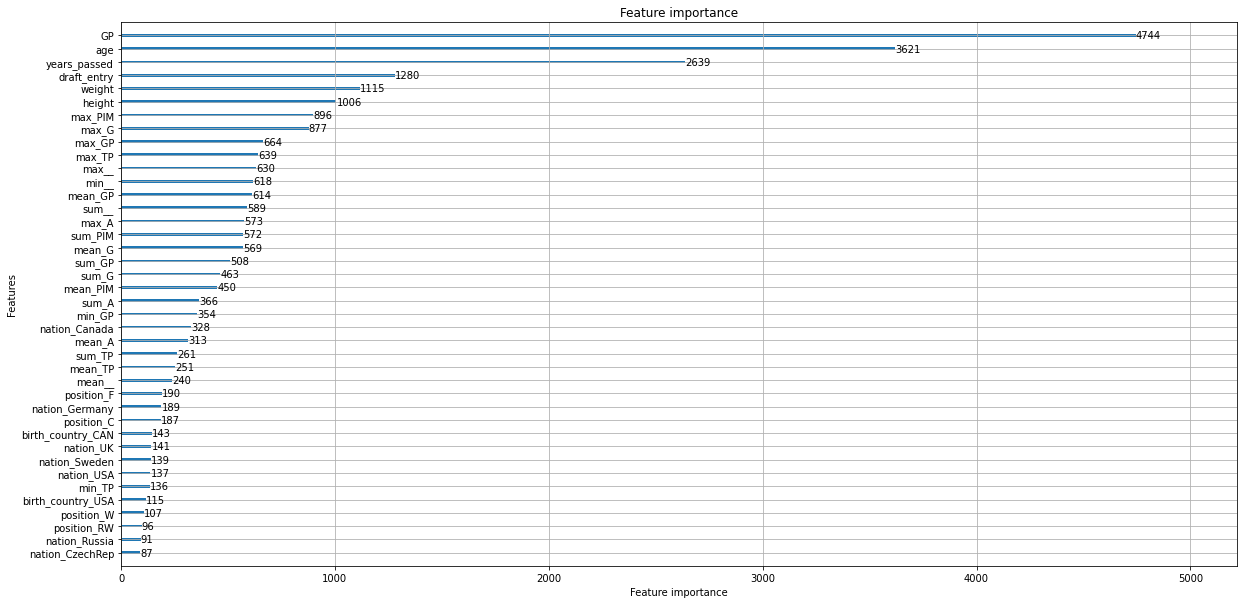

In [227]:
plot_importance(model, max_num_features=40, figsize=(20, 10))